# REGRESION LINEAL MULTIPLE PARA SEGURO MEDICO APLICANDO DATOS CATEGORICOS
## DATASET [kaggle](https://www.kaggle.com/datasets/mirichoi0218/insurance/data)

# PASO 1 - INSTALAMOS E IMPORTAMOS LIBRERIAS

In [3]:
!pip install pyjanitor
import janitor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.4/215.4 kB 3.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import kagglehub
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [6]:
sns.set(style='whitegrid',context='notebook')

# PASO 2 CARGAMOS EL DATASET

In [ ]:
path = kagglehub.dataset_download("mirichoi0218/insurance")
file = '/insurance.csv'

path_file = path + file

print("Path to dataset files:", path_file)


df = pd.read_csv(path_file)
df.head(5)

# PASO 3 : EDA

## VERIFICAMOS NULOS

In [8]:
df.isna().sum().sum()

0

##  ELIMINAMOS OUTLIERS

In [9]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [10]:
df_cleaned = remove_outliers(df,'bmi')
df_cleaned = remove_outliers(df_cleaned,'charges')

df_cleaned.shape

(1191, 7)

# PASO 4 : CODIFICACIÓN DE VARIABLES CATEGORICAS

## IDENTIFICAMOS VARIABLES CATEGORICAS

In [15]:
df = df_cleaned
df.shape

(1191, 7)

In [18]:
df.dtypes

,0
age,int64
sex,object
bmi,float64
children,int64
smoker,object
region,object
charges,float64


In [19]:
categorical_columns = df.select_dtypes(object).columns
categorical_columns

Index(['sex', 'smoker', 'region'], dtype='object')

# CREAMOS LISTA POR TIPO DE CODIFICACIÓN ( ORDINAL Y ONE HOT ENCODING)

In [21]:
for cc in categorical_columns:
  print("*"*50)
  print(df[cc].value_counts())

**************************************************
sex
female    610
male      581
Name: count, dtype: int64
**************************************************
smoker
no     1055
yes     136
Name: count, dtype: int64
**************************************************
region
northwest    305
southeast    301
northeast    295
southwest    290
Name: count, dtype: int64


In [27]:
ordinal_cols = ['sex','smoker']
onehot_cols = list(set(categorical_columns) - set(ordinal_cols))
print(ordinal_cols,onehot_cols)

['sex', 'smoker'] ['region']


## CREAMOS UN TRANSFORMER

In [28]:
import sklearn.compose
import sklearn.preprocessing
transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(),ordinal_cols),
    (sklearn.preprocessing.OneHotEncoder(),onehot_cols),
    remainder='passthrough'
)
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinalencoder', OrdinalEncoder(),
                                 ['sex', 'smoker']),
                                ('onehotencoder', OneHotEncoder(), ['region'])])

## APLICAMOS EL TRANSFOMER A LA VARIABLES CATEGORICAS

In [29]:
data_transformed_df = (
    pd.DataFrame(
        transformer.fit_transform(df),
        columns = transformer.get_feature_names_out(),
        index=df.index
    )
)

data_transformed_df = data_transformed_df.rename(
    columns=lambda x: x.replace("ordinalencoder__", "").replace("onehotencoder__", "").replace("remainder__", "")
)

data_transformed_df

,sex,smoker,region_northeast,region_northwest,region_southeast,region_southwest,age,bmi,children,charges
0,0.0,1.0,0.0,0.0,0.0,1.0,19.0,27.900,0.0,16884.92400
1,1.0,0.0,0.0,0.0,1.0,0.0,18.0,33.770,1.0,1725.55230
2,1.0,0.0,0.0,0.0,1.0,0.0,28.0,33.000,3.0,4449.46200
3,1.0,0.0,0.0,1.0,0.0,0.0,33.0,22.705,0.0,21984.47061
4,1.0,0.0,0.0,1.0,0.0,0.0,32.0,28.880,0.0,3866.85520
...,...,...,...,...,...,...,...,...,...,...
1333,1.0,0.0,0.0,1.0,0.0,0.0,50.0,30.970,3.0,10600.54830
1334,0.0,0.0,1.0,0.0,0.0,0.0,18.0,31.920,0.0,2205.98080
1335,0.0,0.0,0.0,0.0,1.0,0.0,18.0,36.850,0.0,1629.83350
1336,0.0,0.0,0.0,0.0,0.0,1.0,21.0,25.800,0.0,2007.94500


In [30]:
corr_matrix = data_transformed_df.corr()
corr_charges = corr_matrix['charges']
corr_charges.sort_values(ascending=False)

,charges
charges,1.000000
smoker,0.596213
age,0.448798
children,0.089083
region_northeast,0.067055
region_northwest,0.037770
sex,-0.022893
region_southeast,-0.029093
bmi,-0.064483
region_southwest,-0.076394


<Axes: >

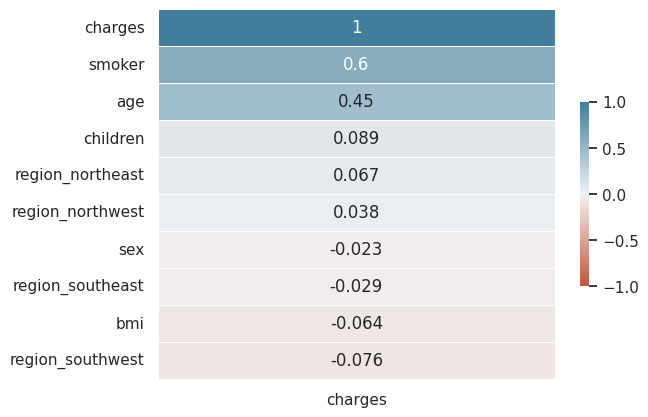

In [32]:
sns.heatmap(
    data=corr_charges.sort_values(ascending=False).to_frame(),
    cmap=sns.diverging_palette(20, 230, as_cmap=True),
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True
)

# PASO 5 : CREACIÓN DEL MODELO DE MACHINE LEARNING

## DIVIDIMOS DATASET EN TRAIN Y TEST Y STANDARIZAMOS VALORES

In [74]:
#X_cols = list(set(data_transformed_df.columns)-set(['charges']))
X_cols = ['smoker','age','region_southwest']
y_col = ['charges']

In [82]:
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

X = data_transformed_df[X_cols].values
y = data_transformed_df[y_col].values

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

sc_x = StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_test = sc_x.fit_transform(X_test)

sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train)
y_test = sc_y.fit_transform(y_test)

#creamos el modelo
model = LinearRegression()
model.fit(X_train,y_train)

y_pred = model.predict(X_test)


#erro cuadratico medio
mse = metrics.mean_squared_error(y_test,y_pred)
#R2 Coeficiente de determinación
r2 = metrics.r2_score(y_test,y_pred)

print(f'El error cuadratico medio(MSE) es de {round(mse,4)}')
print(f'El coeficiente de determinación(R2) es de {round(r2,4)}')

El error cuadratico medio(MSE) es de 0.2773
El coeficiente de determinación(R2) es de 0.7227


# GRAFICAMOS VALORES REALES CON VALORES PREDECIDOS

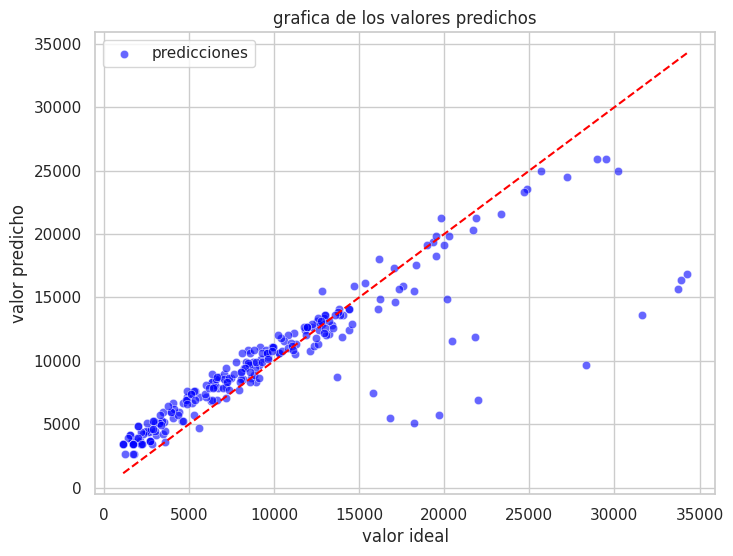

In [83]:
y_test_inv = sc_y.inverse_transform(y_test)
y_pred_inv = sc_y.inverse_transform(y_pred)

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_inv.flatten(),y=y_pred_inv.flatten(),alpha=0.6,color='blue',label='predicciones')
plt.plot([min(y_test_inv),max(y_test_inv)],[min(y_test_inv),max(y_test_inv)],color='red',linestyle='--')

plt.xlabel("valor ideal")
plt.ylabel("valor predicho")
plt.title("grafica de los valores predichos")
plt.legend()
plt.show()

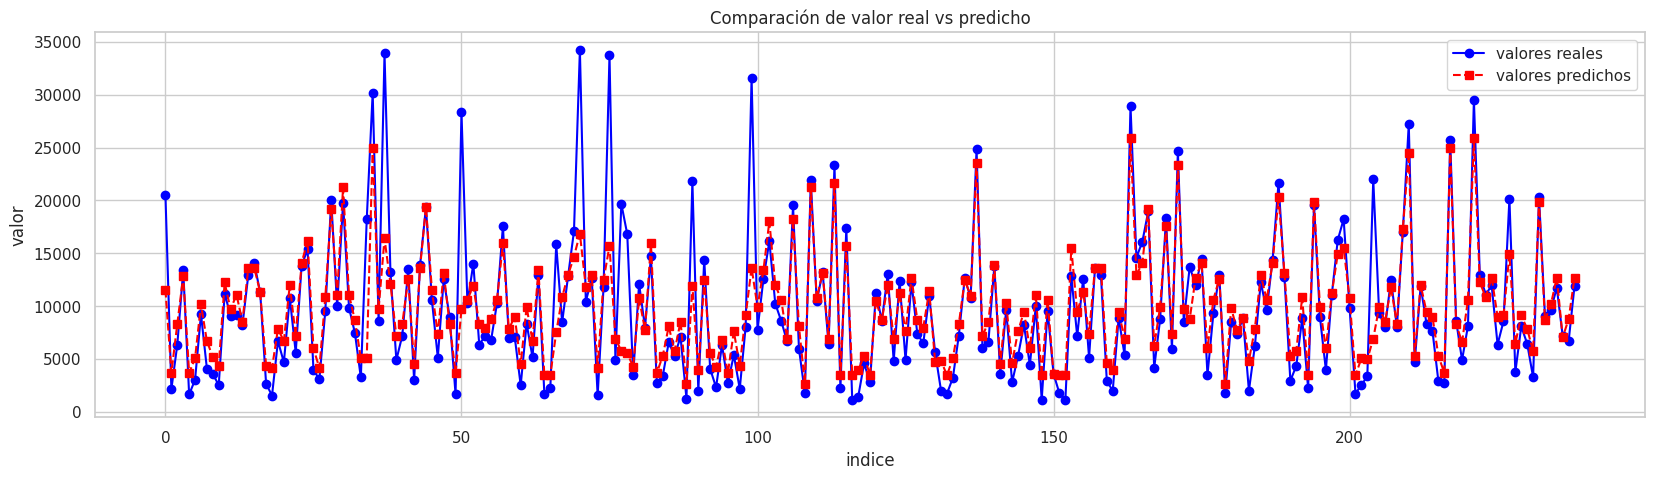

In [84]:
y_test_inv = sc_y.inverse_transform(y_test)
y_pred_inv = sc_y.inverse_transform(y_pred)


plt.figure(figsize=(20,5))
plt.plot(y_test_inv.flatten(),label='valores reales',marker='o',linestyle='-',color='blue')
plt.plot(y_pred_inv.flatten(),label='valores predichos',marker='s',linestyle='--',color='red')


plt.xlabel("indice")
plt.ylabel("valor")
plt.title("Comparación de valor real vs predicho")
plt.legend()
plt.grid(True)
plt.show()
